In [1]:
import sys
sys.path.append('./../gp_sinkhorn/')
from SDE_solver import solve_sde_RK
from utils import plot_trajectories_2
from MLE_drift import *
import MLE_drift

import copy
import torch
import math
import numpy as np

from pyro.contrib.gp.kernels import Exponential, Matern32, RBF, Brownian, Combination, Product, Sum

from celluloid import Camera
from IPython.display import HTML
import matplotlib.pyplot as plt

In [168]:
import pickle
import torch
from gp_sinkhorn.SDE_solver import solve_sde_RK
from gp_sinkhorn.GP import MultitaskGPModel
from gp_sinkhorn.utils import plot_trajectories_2
import matplotlib.pyplot as plt
import pyro.contrib.gp as gp
import math
from tqdm import tqdm
import gc
import copy
import os
import time

def plot_trajectories_2(Xts, t, remove_time=True, fig_axs=None, color='b', show=True, direction="Forward",alpha =0.3):
    """
    Helper function that plots multple trajctories
    """

    fn = 14
    if fig_axs is None:
        fig, axs = plt.subplots(1, 1, sharey=False, figsize=(15, 10))
        axs.set_ylabel("$x(t)$", fontsize=fn)
    else:
        fig, axs = fig_axs

    n, _, _, = Xts.shape

    if remove_time:
        Xts = Xts[..., :-1]

    for i in range(n):
        label = "$\mathbb{Q}$:" + f"{direction} process" if i == 0 else None
        axs.plot(t.cpu().flatten(), Xts[i, :, :].detach().cpu().numpy().flatten(), color+'o-', alpha=alpha, label=label)

    #     plt.show()
    return (fig, axs)


class Feedforward(torch.nn.Module):
    
    def __init__(self, input_size=2, hidden_size=500):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.bn = torch.nn.BatchNorm1d(self.hidden_size)
        self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = torch.nn.Linear(self.hidden_size, input_size-1)
       
        
    def forward(self, x):
#         import pdb; pdb.set_trace()
        hidden = (self.fc1(x))
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.relu(output)
        output = self.fc3(output)
        return output
    
    def predict(self, x, debug=False):
        return self.forward(x) 
    

def train_nn(model, x_train, y_train):
    
#     optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
    
    model.train()
    epoch = 500
    for epoch in range(epoch):
        optimizer.zero_grad()
        # Forward pass
        y_pred = model(x_train)
        # Compute Loss
        diff = y_train - y_pred
        loss = torch.matmul(torch.transpose(diff, 0, 1), diff) / diff.shape[0]
#         loss = loss_criteria(y_pred.squeeze(), y_train)

#         print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
        # Backward pass
        loss.backward(retain_graph=True)
        optimizer.step()
    return model

class LinearRegression:
    def fit(self, X, y, method="lin", learning_rate=0.001, iterations=500, batch_size=32):
#         X, y = torch.from_numpy(X), torch.from_numpy(y)
        X = torch.cat([(X), torch.ones_like(y)], dim=1)
        rows, cols = X.size()
        if method=="lin":
            if rows >= cols == torch.matrix_rank(X):
                self.weights = torch.matmul(
                    torch.matmul(
                        torch.inverse(
                            torch.matmul(
                                torch.transpose(X, 0, 1),
                                X)),
                        torch.transpose(X, 0, 1)),
                    y)
        elif method == 'sgd':
            self.weights = torch.normal(mean=0, std=1/cols, size=(cols, 1), dtype=torch.float64)
            for i in range(iterations):
                Xy = torch.cat([X, y], dim=1)
                Xy = Xy[torch.randperm(Xy.size()[0])]
                X, y = torch.split(Xy, [Xy.size()[1]-1, 1], dim=1)
                for j in range(int(math.ceil(rows/batch_size))):
                    start, end = batch_size*j, min(batch_size*(j+1), rows)
                    Xb = torch.index_select(X, 0, torch.arange(start, end))
                    yb = torch.index_select(y, 0, torch.arange(start, end))
                    
                    self.weights.requires_grad_(True)
                    diff = torch.matmul(Xb, self.weights) - yb
                    loss = torch.matmul(torch.transpose(diff, 0, 1), diff)
                    loss.backward()
                    
                    self.weights = (self.weights - learning_rate*self.weights.grad).detach()
    
    def predict(self, X, debug=False):

        X = torch.cat([X, torch.ones((X.size()[0], 1))], dim=1)


        return torch.matmul(X, self.weights)


def fit_drift_nn(
    Xts,N,dt,
    num_data_points=10, num_time_points=50, 
    kernel=gp.kernels.RBF, noise=1.0, gp_mean_function=None,
    ):
    """
    This function transforms a set of timeseries into an autoregression problem and
    estimates the drift function using GPs following:
    
        - Papaspiliopoulos, Omiros, Yvo Pokern, Gareth O. Roberts, and Andrew M. Stuart.
          "Nonparametric estimation of diffusions: a differential equations approach."
          Biometrika 99, no. 3 (2012): 511-531.
        - Ruttor, A., Batz, P., & Opper, M. (2013).
          "Approximate Gaussian process inference for the drift function in stochastic differential equations."
          Advances in Neural Information Processing Systems, 26, 2040-2048.
    
    :param Xts[MxNxD ndarray]: Array containing M timeseries of length N of dimension D
    :param N [int]: Number of samples in the time series
    :param dt [float]: time interval seperation between time points (sample rate)
    
    :param num_data_points[int]: Number of inducing samples(inducing points) from the boundary distributions
    :param num_time_points[int]: Number of inducing timesteps(inducing points) for the EM approximation
    
    :return [nx(d+1) ndarray-> nxd ndarray]: returns fitted drift
    """
    X_0 = Xts[:, 0, 0].reshape(-1, 1)  # Extract starting point
    Ys = ((Xts[:, 1:, :-1] - Xts[:, :-1, :-1])  ).reshape((-1, Xts.shape[2] - 1)) # Autoregressive targets y = (X_{t+e} - X_t)/dt
    Xs = Xts[:, :-1, :].reshape((-1, Xts.shape[2])) # Drop the last timepoint in each timeseries
    
    n,d = Xs.shape

    nn_drift_model = Feedforward(input_size=d).double()#Setup the NN
    train_nn(nn_drift_model, Xs, Ys)

#     nn_drift_model = LinearRegression()
#     nn_drift_model.fit(Xs, Ys, method="lin")
#     nn_drift_model.eval()
    # fit_gp(gp_drift_model, num_steps=5) # Fit the drift
    
    def gp_ou_drift(x,debug=False):
        return nn_drift_model.predict(x, debug=debug)  /dt
#     gp_ou_drift = lambda x,debug: gp_drift_model.predict(x, debug=debug)  # Extract mean drift
    return gp_ou_drift

# Generating OU Based data

Here we simmulate some OU data using the EM SDE Solver . We will use this data to fit forwards and backwards drifts.

In [117]:
theta = 7.0
sigma = 0.3
dt = 0.01
N = int(math.ceil(1.0/dt))
b_drift = lambda x: -theta * x[...,:-1] 

In [118]:
num_samples = 100
dim = 1
mu, std = 5, 0.01
X_0 = torch.distributions.normal.Normal(loc=mu, scale=std).sample((num_samples, dim)) #.reshape(num_samples, dim,-1)

In [119]:
t, Xts = solve_sde_RK(b_drift=b_drift,sigma=sigma, X0=X_0, dt=dt, N=N)

(<Figure size 1080x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1cb0ebdd550>)

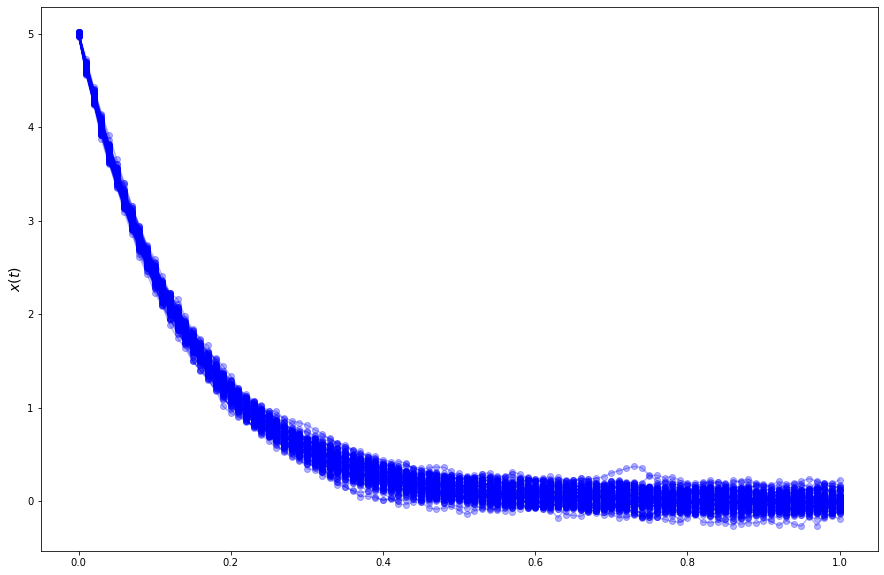

In [120]:
plot_trajectories_2(Xts, t, remove_time=True)

# Fitting Forward Drift with GP
In this section we demonstrate how to fit the forwards drift of an OU process using the GP drift fraemwork. Theres a small problem using Pyro I dont know why it doesnt let me flatten Ys , does it not support multioutput formats for GPs ?

Epoch 0: train loss: 0.0016018748781196858
Epoch 1: train loss: 16.52465527615893
Epoch 2: train loss: 1.7608574054589579
Epoch 3: train loss: 0.012152426504908883
Epoch 4: train loss: 0.004667741475602356
Epoch 5: train loss: 0.010630560124732593
Epoch 6: train loss: 0.018174184903130337
Epoch 7: train loss: 0.023575264674637494
Epoch 8: train loss: 0.024797400957573455
Epoch 9: train loss: 0.02236180940692903
Epoch 10: train loss: 0.017935306219532845
Epoch 11: train loss: 0.013162883577879137
Epoch 12: train loss: 0.009163891954163369
Epoch 13: train loss: 0.006463056820707737
Epoch 14: train loss: 0.0051203208755334515
Epoch 15: train loss: 0.004903690285652734
Epoch 16: train loss: 0.005442116347837483
Epoch 17: train loss: 0.00634754534187037
Epoch 18: train loss: 0.00728601120051448
Epoch 19: train loss: 0.00801541011578863
Epoch 20: train loss: 0.008396010222016073
Epoch 21: train loss: 0.008383369295072583
Epoch 22: train loss: 0.00800674123252208
Epoch 23: train loss: 0.00734

Epoch 186: train loss: 0.000923018019996939
Epoch 187: train loss: 0.0009229376133627388
Epoch 188: train loss: 0.0009228594714044611
Epoch 189: train loss: 0.000922783542390266
Epoch 190: train loss: 0.0009227090251120423
Epoch 191: train loss: 0.0009226360155086985
Epoch 192: train loss: 0.0009225648122502299
Epoch 193: train loss: 0.0009224957514191967
Epoch 194: train loss: 0.0009224293502010207
Epoch 195: train loss: 0.0009223656521313396
Epoch 196: train loss: 0.0009223046043054398
Epoch 197: train loss: 0.0009222461198058268
Epoch 198: train loss: 0.000922190167790386
Epoch 199: train loss: 0.0009221361968592493
Epoch 200: train loss: 0.0009220839505812272
Epoch 201: train loss: 0.0009220334533080349
Epoch 202: train loss: 0.0009219847268151922
Epoch 203: train loss: 0.0009219376195035071
Epoch 204: train loss: 0.0009218917009534124
Epoch 205: train loss: 0.000921847324958237
Epoch 206: train loss: 0.0009218043690538945
Epoch 207: train loss: 0.0009217624260719445
Epoch 208: tra

Epoch 370: train loss: 0.0009194672990723422
Epoch 371: train loss: 0.0009194600574026538
Epoch 372: train loss: 0.0009194526883944546
Epoch 373: train loss: 0.0009194453653207301
Epoch 374: train loss: 0.0009194381450804746
Epoch 375: train loss: 0.0009194309766393932
Epoch 376: train loss: 0.0009194238241818367
Epoch 377: train loss: 0.0009194166615611048
Epoch 378: train loss: 0.0009194095011239039
Epoch 379: train loss: 0.0009194023489678976
Epoch 380: train loss: 0.0009193952156220359
Epoch 381: train loss: 0.0009193881233911097
Epoch 382: train loss: 0.0009193811008798349
Epoch 383: train loss: 0.000919374316669639
Epoch 384: train loss: 0.0009193673008078383
Epoch 385: train loss: 0.0009193604060551824
Epoch 386: train loss: 0.0009193534290200606
Epoch 387: train loss: 0.0009193465561669774
Epoch 388: train loss: 0.0009193397274789863
Epoch 389: train loss: 0.0009193328661683548
Epoch 390: train loss: 0.000919326059345078
Epoch 391: train loss: 0.0009193193419889305
Epoch 392: t

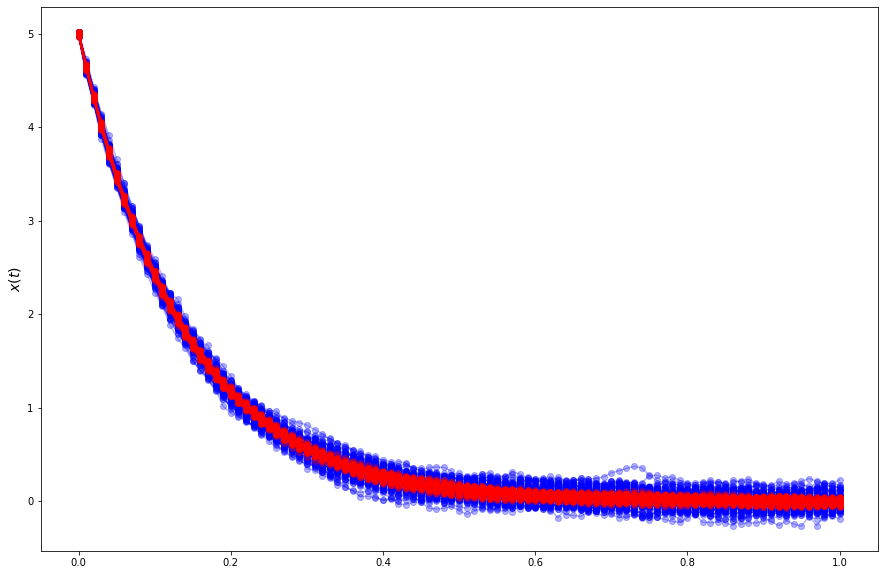

In [121]:
from functools import partial
# kern = partial(RBF, variance=torch.tensor(0.00000001), lengthscale=torch.tensor(0.05))
# kern = partial(RBF, variance=torch.tensor(dt**2), lengthscale=torch.tensor(1))
from importlib import reload

# def kern_(input_dim, variance=None):
#     return RBF(input_dim=input_dim, variance=torch.tensor(dt**2), lengthscale=torch.tensor(1))
# inpu
# print(kern.variance)
# reload(MLE_drift)
# gp_ou_drift = fit_drift(Xts,N,dt,noise=sigma, kernel=kern)
gp_ou_drift_ = fit_drift_nn(Xts,N,dt,noise=sigma, kernel=None)
gp_ou_drift_2 = lambda x: gp_ou_drift_(x)


t_hat, Xts_hat = solve_sde_RK(b_drift=gp_ou_drift_2,sigma=sigma**2, X0=X_0, dt=dt, N=N) # Solver using GP predicted drift
fig_axs = plot_trajectories_2(Xts, t, remove_time=True, show=False)
plot_trajectories_2(Xts_hat, t_hat, remove_time=True, fig_axs=fig_axs, color='r');

# Fitting Backwards Drift with GP

In this section we reverse the time series before passing it to the GP. Then we inspect that if starting from the empirical hitting distribution of the OU process namely $X_1$ , where does our GP drift take us to, if correct it should take us back to $X_0$ .

Epoch 0: train loss: 0.020251215205433253
Epoch 1: train loss: 11.432652409406623
Epoch 2: train loss: 1.3155434122347984
Epoch 3: train loss: 0.01203769341148643
Epoch 4: train loss: 0.010029187644407895
Epoch 5: train loss: 0.026636647644680586
Epoch 6: train loss: 0.03921620299741295
Epoch 7: train loss: 0.040446132296466646
Epoch 8: train loss: 0.0302030956354222
Epoch 9: train loss: 0.01715197006105535
Epoch 10: train loss: 0.006867284316409319
Epoch 11: train loss: 0.002679317518355811
Epoch 12: train loss: 0.004947077714388755
Epoch 13: train loss: 0.00957448573910037
Epoch 14: train loss: 0.011922091787102185
Epoch 15: train loss: 0.00967216069507948
Epoch 16: train loss: 0.005377783098597945
Epoch 17: train loss: 0.0016606963577619279
Epoch 18: train loss: 0.0015040993235835491
Epoch 19: train loss: 0.0038571425725253895
Epoch 20: train loss: 0.004582340017099444
Epoch 21: train loss: 0.003392219812371485
Epoch 22: train loss: 0.0018697114349991942
Epoch 23: train loss: 0.0011

Epoch 186: train loss: 0.0009616901712702527
Epoch 187: train loss: 0.000961598411533592
Epoch 188: train loss: 0.0009615210941327112
Epoch 189: train loss: 0.0009614638886122286
Epoch 190: train loss: 0.0009613983299115582
Epoch 191: train loss: 0.0009613157647124572
Epoch 192: train loss: 0.0009612361010898855
Epoch 193: train loss: 0.0009611741744945892
Epoch 194: train loss: 0.0009611168320447773
Epoch 195: train loss: 0.0009610464624473971
Epoch 196: train loss: 0.0009609708912890365
Epoch 197: train loss: 0.0009609028885227156
Epoch 198: train loss: 0.0009608411320165925
Epoch 199: train loss: 0.0009607737130803
Epoch 200: train loss: 0.0009606999451606693
Epoch 201: train loss: 0.0009606313545796006
Epoch 202: train loss: 0.0009605706576287506
Epoch 203: train loss: 0.0009605070317003706
Epoch 204: train loss: 0.0009604371050648897
Epoch 205: train loss: 0.0009603683825012624
Epoch 206: train loss: 0.0009603046034835959
Epoch 207: train loss: 0.0009602412608056257
Epoch 208: tra

Epoch 369: train loss: 0.0009517200609391388
Epoch 370: train loss: 0.000951681802161305
Epoch 371: train loss: 0.0009516431487999638
Epoch 372: train loss: 0.0009516058403787561
Epoch 373: train loss: 0.0009515684701629347
Epoch 374: train loss: 0.0009515322706302754
Epoch 375: train loss: 0.0009514968759001741
Epoch 376: train loss: 0.000951462018832599
Epoch 377: train loss: 0.0009514275279401614
Epoch 378: train loss: 0.0009513934216737651
Epoch 379: train loss: 0.0009513592045908762
Epoch 380: train loss: 0.0009513251579316485
Epoch 381: train loss: 0.0009512911747056524
Epoch 382: train loss: 0.0009512571362854353
Epoch 383: train loss: 0.0009512238881597263
Epoch 384: train loss: 0.000951191678759826
Epoch 385: train loss: 0.0009511602075063486
Epoch 386: train loss: 0.0009511299334340244
Epoch 387: train loss: 0.000951099801212588
Epoch 388: train loss: 0.0009510694557178055
Epoch 389: train loss: 0.0009510390897841073
Epoch 390: train loss: 0.000951008142143686
Epoch 391: trai

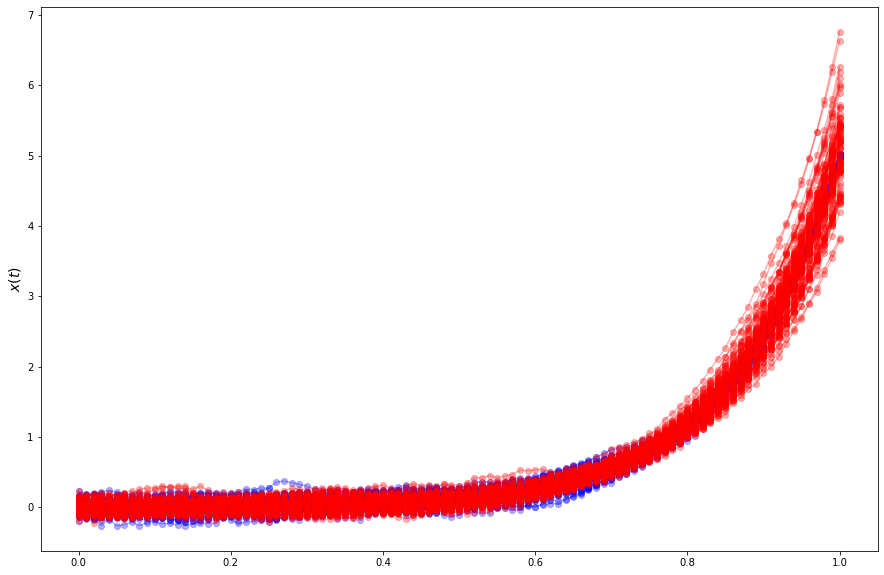

In [122]:

Xbts = copy.deepcopy(Xts)
Xbts[:,:,0] = Xbts[:,:,0].flip(1) # Reverse the series


# kern = partial(Exponential, lengthscale=torch.tensor(0.01))
# kern = partial(RBF, variance=torch.tensor(dt**2), lengthscale=torch.tensor(1))
# kern = partial(RBF, variance=torch.tensor(1), lengthscale=torch.tensor(1))


gp_ou_drift = fit_drift_nn(Xbts,N,dt, noise=sigma**2, kernel=None)
# gp_ou_drift_2 = lambda x: -gp_ou_drift_(x)

tb_hat, Xbts_hat = solve_sde_RK(b_drift=gp_ou_drift,sigma=sigma, X0=Xbts[:,0,0].reshape((-1,1)), dt=dt, N=N) # Solver using GP predicted drift

fig_axs = plot_trajectories_2(Xbts, t, remove_time=True, show=False)
plot_trajectories_2(Xbts_hat, tb_hat, remove_time=True, fig_axs=fig_axs, color='r');

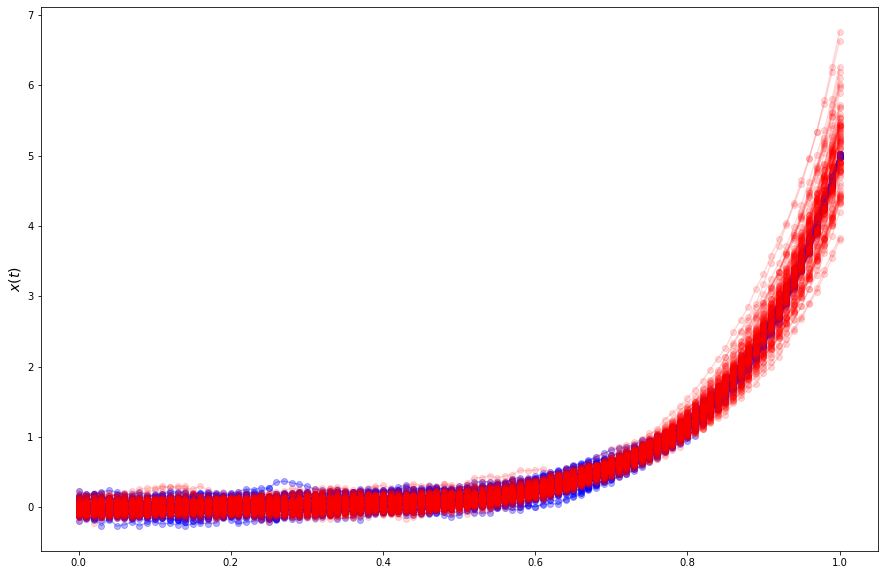

In [124]:
fig_axs = plot_trajectories_2(Xbts, t, remove_time=True, show=False)
plot_trajectories_2(Xbts_hat, tb_hat, remove_time=True, fig_axs=fig_axs, color='r', alpha=0.15);

#  IPFP

In [134]:
theta = 7.0
sigma = 1
dt = 0.05
N = int(math.ceil(1.0/dt))
b_drift = lambda x: -theta * x[...,:-1] 

num_samples = 30
X_0 = torch.distributions.normal.Normal(loc=0, scale=0.5).sample((num_samples, 1)) #.reshape(num_samples, dim,-1)

X_1_a = torch.distributions.normal.Normal(loc=1.8, scale=0.6**2).sample((num_samples//2, 1)) 
X_1_b = torch.distributions.normal.Normal(loc=-1.9, scale=0.6**2).sample((num_samples//2, 1))
X_1 = torch.cat((X_1_a,X_1_b))

In [169]:
def MLE_IPFP(
        X_0,X_1,N=10,sigma=1,iteration=10, prior_drift=None,
        num_data_points=10, num_time_points=50, prior_X_0=None, prior_Xts=None,
        num_data_points_prior=None, num_time_points_prior=None, plot=False,
        kernel=gp.kernels.RBF, observation_noise=1.0, decay_sigma=1, refinement_iterations=5,
        div =1, gp_mean_prior_flag=False,log_dir=None,verbose=0, langevin=False, nn=False
    ):
    """
    This module runs the GP drift fit variant of IPFP it takes in samples from \pi_0 and \pi_1 as
    well as a the forward drift of the prior \P and computes an estimate of the Schroedinger Bridge
    of \P,\pi_0,\pi_1:
    
                        \Q* = \argmin_{\Q \in D(\pi_0, \pi_1)} KL(\Q || \P)
    
    :params X_0[nxd ndarray]: Source distribution sampled from \pi_0 (initial value for the bridge)
    :params X_1[mxd ndarray]: Target distribution sampled from \pi_1 (terminal value for the bridge)
    
    :param N[int]: number of timesteps for Euler-Mayurama discretisations
    :param iteration[int]: number of IPFP iterations
    
    :param prior_drift[nx(d+1) ndarray-> nxd ndarray]: drift function of the prior, defautls to Brownian

    :param num_data_points[int]: Number of inducing samples(inducing points) from the boundary distributions
    :param num_time_points[int]: Number of inducing timesteps(inducing points) for the EM approximation
    
    :param prior_X_0[mxd array]: The marginal for the prior distribution \P . This is a free parameter
                                 which can be tweaked to encourage exploration and improve results.

    :param prior_Xts[nxTxd array] : Prior trajectory that can be used on the first iteration of IPML
    :param num_data_points_prior[int]: number of data inducing points to use for the prior backwards drift
                                       estimation prior to the IPFP loop and thus can afford to use more
                                       samples here than with `num_data_points`. Note starting off IPFP
                                       with a very good estimate of the backwards drift of the prior is
                                       very important and thus it is encouraged to be generous with this
                                       parameter.
    :param num_time_points_prior[int]: number of time step inducing points to use for the prior backwards
                                       drift estimation. Same comments as with `num_data_points_prior`.
    :param decay_sigma[float]: Decay the noise sigma at each iteration.
    :param log_dir[str]: Directory to log the result. If None don't log.
    
    :return: At the moment returning the fitted forwards and backwards timeseries for plotting. However
             should also return the forwards and backwards drifts. 
    """

    if prior_drift is None:
        prior_drift = lambda x: torch.tensor([0]*(x.shape[1]-1)).reshape((1,-1)).repeat(x.shape[0],1)
        
    if nn:
        fit_drift = fit_drift_nn
#         bbb
    # Setup for the priors backwards drift estimate
    prior_X_0 = X_0 if prior_X_0 is None else prior_X_0        
    num_data_points_prior = num_data_points if num_data_points_prior is None else num_data_points_prior
    num_time_points_prior = num_time_points if num_time_points_prior is None else num_time_points_prior
    drift_forward = None
        
    dt = 1.0 / N
    
    pow_ = int(math.floor(iteration / div))
    observation_noise = sigma**2 if decay_sigma == 1.0 else (sigma * (decay_sigma**pow_))**2
    
    if langevin:
        d = sigma.shape[0]
        sigma[:int(d * 0.5)] = 0
    
    # Estimating the backward drift of brownian motion
    # Start in prior_X_0 and go forward. Then flip the series and learn a backward drift: drift_backward
    t, Xts = solve_sde_RK(b_drift=prior_drift, sigma=sigma, X0=prior_X_0, dt=dt, N=N)

    T_,M_ = copy.deepcopy(t),copy.deepcopy(Xts)
#     if plot: plot_trajectories_2(Xts, t)

    if prior_Xts is not None:
        Xts[:,:,:-1] = prior_Xts.flip(1) # Reverse the series
    else:
        Xts[:,:,:-1] = Xts[:,:,:-1].flip(1) # Reverse the series

    drift_backward = fit_drift(
        Xts,N=N,dt=dt,num_data_points=num_data_points_prior,
        num_time_points=num_time_points_prior, kernel=kernel, noise=observation_noise, gp_mean_function=prior_drift

    )
    
    
    
    if plot:
        plot_pendulum(Xts, t,prior_X_0, X_1, color="g", alpha=0.5)
        plt.show()
        T2, M2 = solve_sde_RK(b_drift=drift_backward, sigma=sigma, X0=X_1, dt=dt, N=N)
        T3, M3 = solve_sde_RK(b_drift=drift_backward, sigma=sigma, X0=Xts[:,0,:-1], dt=dt, N=N)
    #     tmp =torch.cat((M2[:,:,:6], M3[:,:,:6]),axis=2)
    #     print(tmp.shape, T2.shape)
    #     axs = plot_pendulum(tmp, T2,color="r", alpha=0.6)
        print("PLOT")
        axs = plot_pendulum(M2, T2,X_0, X_1, color="r", alpha=0.5)
    #     import pdb; pdb.set_trace()
        plot_pendulum(M3[:,:,:], T3,X_0, X_1, axs=axs,color="b", alpha=0.5)
    #     plot_pendulum(M3, T3,axs=axs,color="b", alpha=0.5)
        plt.show()
        plot_pendulum(M2, T2,X_0, X_1, color="r", alpha=0.5)

    result = []
    
    prior_drift_backward = copy.deepcopy(drift_backward)
    
    iterations = iteration

    for i in tqdm(range(iterations)):
        # Estimate the forward drift
        # Start from the end X_1 and then roll until t=0
        if verbose:
            print("Solve drift forward ")
            t0 = time.time()
        t, Xts = solve_sde_RK(b_drift=drift_backward, sigma=sigma, X0=X_1,dt=dt, N=N)
        if verbose:
            print("Forward drift solved in ",time.time()-t0)
        del drift_forward
        gc.collect()
        #plot_trajectories_2(Xts, t)
        T2,M2 = copy.deepcopy(torch.tensor(t)),copy.deepcopy(torch.tensor(Xts))
        
        if i == 0: result.append([T_, M_, T2, M2])
        # Reverse the series
        Xts[:,:,:-1] = Xts[:,:,:-1].flip(1)

        if verbose:
            print("Fit drift")
            t0 = time.time()
        drift_forward = fit_drift(
            Xts,N=N,dt=dt, num_data_points=num_data_points,
            num_time_points=num_time_points, kernel=kernel, noise=observation_noise,
            gp_mean_function=(prior_drift if gp_mean_prior_flag else None)
        )
        if verbose:
            print("Fitting drift solved in ",time.time()-t0)

        # Estimate backward drift
        # Start from X_0 and roll until t=1 using drift_forward
        # HERE: HERE is where the GP prior kicks in and helps the most
        t, Xts = solve_sde_RK(b_drift=drift_forward, sigma=sigma, X0=X_0,dt=dt, N=N)
        del drift_backward
        gc.collect()

        T,M = copy.deepcopy(torch.tensor(t.detach())),copy.deepcopy(torch.tensor(Xts.detach()))
        # Reverse the series
        Xts[:,:,:-1] = Xts[:,:,:-1].flip(1)

        drift_backward = fit_drift(
            Xts,N=N,dt=dt, num_data_points=num_data_points,
            num_time_points=num_time_points, kernel=kernel, noise=observation_noise,
            gp_mean_function=(prior_drift if gp_mean_prior_flag else None)
                                   # One wouuld think this should (worth rethinking this)
                                   # be prior drift backwards here
                                   # but that doesnt work as well,
                                   # Its kinda clear (intuitively)
                                   # that prior_drift backwards
                                   # as a fallback is not going to help
                                   # this prior, instead the prior of this GP
                                   # should be inherting the backwards drift
                                   # of the GP at iteration 1 sadly we dont 
                                   # have such an estimate thus this should be None
            
        )
#         if plot:
#             plot_trajectories_2(M2, T2)
#             plot_trajectories_2(M, T, color='r')
        result.append([T, M, T2, M2])
        if i < iteration and i % div == 0:
            sigma *= decay_sigma
#             observation_noise = sigma**2
        gc.collect() # fixes odd memory leak
        if log_dir != None :
            pickle.dump(result,open(log_dir+ "/result_"+str(i)+".pkl","wb"))


    
    T2, M2 = solve_sde_RK(b_drift=drift_backward, sigma=sigma, X0=X_1, dt=dt, N=N)
    if iterations == 0 : return [(None, None, T2, M2)]
    
    T, M = solve_sde_RK(b_drift=drift_forward, sigma=sigma, X0=X_0, dt=dt, N=N)
    result.append([T, M, T2, M2])
    if log_dir != None:
        pickle.dump(result, open(log_dir + "/result_final.pkl", "wb"))
    if plot:
#         plot_pendulum(Xts, t,prior_X_0, X_1, color="g", alpha=0.5)
#         plt.show()
        T2, M2 = solve_sde_RK(b_drift=drift_backward, sigma=sigma, X0=X_1, dt=dt, N=N)
        T3, M3 = solve_sde_RK(b_drift=drift_forward, sigma=sigma, X0=X_0, dt=dt, N=N)
    #     tmp =torch.cat((M2[:,:,:6], M3[:,:,:6]),axis=2)
    #     print(tmp.shape, T2.shape)
    #     axs = plot_pendulum(tmp, T2,color="r", alpha=0.6)
        print("PLOT")
        axs = plot_pendulum(M3, T3,X_0, X_1, color="r", alpha=0.5)
    #     import pdb; pdb.set_trace()
#         plot_pendulum(M3, T3,X_0, X_1, axs=axs,color="b", alpha=0.5)
    #     plot_pendulum(M3, T3,axs=axs,color="b", alpha=0.5)
        plt.show()
#         plot_pendulum(M2, T2,prior_X_0, X_1, color="r", alpha=0.5)
    return result

In [170]:
prior_X_0=torch.cat((X_1,X_0))
prior_X_0.shape

torch.Size([60, 1])

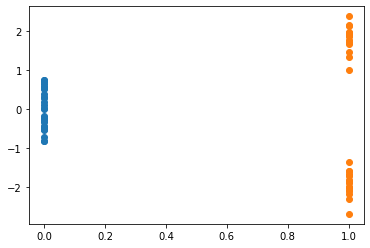

In [171]:
plt.scatter([0]*X_0.shape[0],X_0)
plt.scatter([1]*X_0.shape[0],X_1)

In [ ]:
result = MLE_IPFP(X_0,X_1,prior_X_0=prior_X_0, num_data_points=25, num_time_points=9, N=N, nn=True, iteration=5)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s] <ipython-input-169-65971fa41183>:120: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 <ipython-input-169-65971fa41183>:144: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 50%|█████████████████████████████████████████▌                                         | 5/10 [05:00<05:03, 60.61s/it]

In [ ]:
T,M,T2,M2 = result[-1]
plot_trajectories_2(M,T)
plot_trajectories_2(M2,  T2)

# 2D example

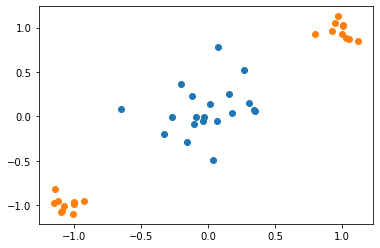

In [32]:
num_samples = 10
N = 100
X_0 = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2),torch.eye(2)*0.05).sample((num_samples*2,1)).reshape((-1,2))

X_1_a = torch.distributions.multivariate_normal.MultivariateNormal(torch.ones(2),torch.eye(2)*0.01).sample((num_samples,1)).reshape((-1,2))
X_1_b = torch.distributions.multivariate_normal.MultivariateNormal(torch.ones(2)*-1,torch.eye(2)*0.01).sample((num_samples,1)).reshape((-1,2))
X_1 = torch.cat((X_1_a,X_1_b))

# TO reshape
plt.scatter(X_0[:,0],X_0[:,1])
plt.scatter(X_1[:,0],X_1[:,1])


In [33]:
result = MLE_IPFP(X_0,X_1,N=N,sigma=0.3, iteration=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:20<00:00,  1.34s/it]


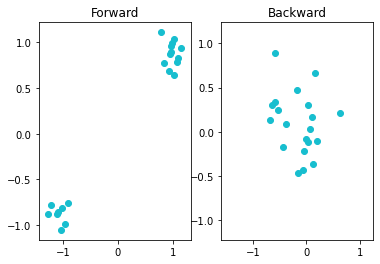

In [35]:
fig, (ax1, ax2) =  plt.subplots(1, 2)
camera = Camera(fig)
M = result[-1][1]
M2 = result[-1][3]
for i in range(N):    
    ax1.scatter(M[:,i,0].detach(),M[:,i,1].detach())
    ax2.scatter(M2[:,i,0].detach(),M2[:,i,1].detach())
    ax1.set_title("Forward")
    ax2.set_title("Backward")
    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())
#animation.save('animation.mp4')
